<a href="https://colab.research.google.com/github/EcoClim/Classification_Model/blob/main/Classification_for_EcoIdentify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**EcoIdentify**
## **Classifying Recycling Material**
###Built by EcoClim Solutions

---
Garbage classification involves separating wastes according to how it's handled or processed. It's important for recycling as some materials are recyclable and others are not.


![AI Logo](https://ecoclimsolutions.files.wordpress.com/2023/12/rmcai.png?resize=219%2C219)
---

The objective of the notebook is to build a model that helps to classify recycling material, known as EcoIdentify

---
Do not copy any/all parts of this code without direct permissions from the official company.  Enjoy!

#**1. Dataset**

### **About The Data And Datasets:**
* The [Dataset](https://drive.google.com/file/d/1brl6_ul9a0ILv0bylr_7ggrIQIhEBAx6/view?usp=drive_link) used is an altered version of a [Dataset](https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification) found in Kaggle
* The total number of images in the dataset is 2527.
* The dataset has 6 different classes.
* **The number of images in each class varies**.
  * The **_Paper_** class has 594 images
  * The  **_Cardboard_** class has 403 images
  * The  **_Plastic_** class has 482 images
  * The  **_Glass_** class has 501 images
  * The  **_Metal_** class has 410 images
  * The  **_Trash_** class has 137 images

##**1.1 Importing Dependencies And Mounting Drive**





In [1]:
#Importing Dependencies
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
#Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **1.2 Downloading and Storing the Dataset**

In [3]:
#Downloading Dataset
!gdown 1brl6_ul9a0ILv0bylr_7ggrIQIhEBAx6

Downloading...
From (original): https://drive.google.com/uc?id=1brl6_ul9a0ILv0bylr_7ggrIQIhEBAx6
From (redirected): https://drive.google.com/uc?id=1brl6_ul9a0ILv0bylr_7ggrIQIhEBAx6&confirm=t&uuid=895bb1bb-d7b9-42ca-bf3a-f26d01b45b10
To: /content/Dataset.zip
100% 42.7M/42.7M [00:01<00:00, 32.5MB/s]


In [4]:
#Changing location of Dataset
!mv /content/Dataset.zip /content/drive/MyDrive/Dataset.zip

In [5]:
#Unizipping the Datset
!unzip '/content/drive/MyDrive/Dataset.zip' -d my_data

Archive:  /content/drive/MyDrive/Dataset.zip
   creating: my_data/Dataset/cardboard/
  inflating: my_data/Dataset/cardboard/cardboard1.jpg  
  inflating: my_data/Dataset/cardboard/cardboard10.jpg  
  inflating: my_data/Dataset/cardboard/cardboard100.jpg  
  inflating: my_data/Dataset/cardboard/cardboard101.jpg  
  inflating: my_data/Dataset/cardboard/cardboard102.jpg  
  inflating: my_data/Dataset/cardboard/cardboard103.jpg  
  inflating: my_data/Dataset/cardboard/cardboard104.jpg  
  inflating: my_data/Dataset/cardboard/cardboard105.jpg  
  inflating: my_data/Dataset/cardboard/cardboard106.jpg  
  inflating: my_data/Dataset/cardboard/cardboard107.jpg  
  inflating: my_data/Dataset/cardboard/cardboard108.jpg  
  inflating: my_data/Dataset/cardboard/cardboard109.jpg  
  inflating: my_data/Dataset/cardboard/cardboard11.jpg  
  inflating: my_data/Dataset/cardboard/cardboard110.jpg  
  inflating: my_data/Dataset/cardboard/cardboard111.jpg  
  inflating: my_data/Dataset/cardboard/cardboard1

In [6]:
#Declaring the Dataset's path as a variable
data_dir = 'my_data/Dataset/'

##**1.3 Reviewing the Dataset**

In [7]:
#Reviewing number of files and directories in the Dataset
total_dir = len(os.listdir(data_dir))
total_files = 0

for dirname, _, filenames in os.walk(data_dir):
    print('counting:', dirname)
    files_counter = 0
    for file in filenames:
        files_counter += 1
    total_files += files_counter
    print('total files in dir:', files_counter)

print('--------')
print('total number of files',total_files)
print('total number of directories',total_dir)

counting: my_data/Dataset/
total files in dir: 5
counting: my_data/Dataset/paper
total files in dir: 594
counting: my_data/Dataset/glass
total files in dir: 501
counting: my_data/Dataset/plastic
total files in dir: 482
counting: my_data/Dataset/metal
total files in dir: 410
counting: my_data/Dataset/trash
total files in dir: 137
counting: my_data/Dataset/cardboard
total files in dir: 403
--------
total number of files 2532
total number of directories 11


##**1.4 Adjusting The Dataset**

In [8]:
#Creating the Training and Validation Datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=100
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=100
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


##**1.5 Validating The Dataset**

In [9]:
#Geting class names
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


##**1.6 Viewing And Inspecting The Dataset**

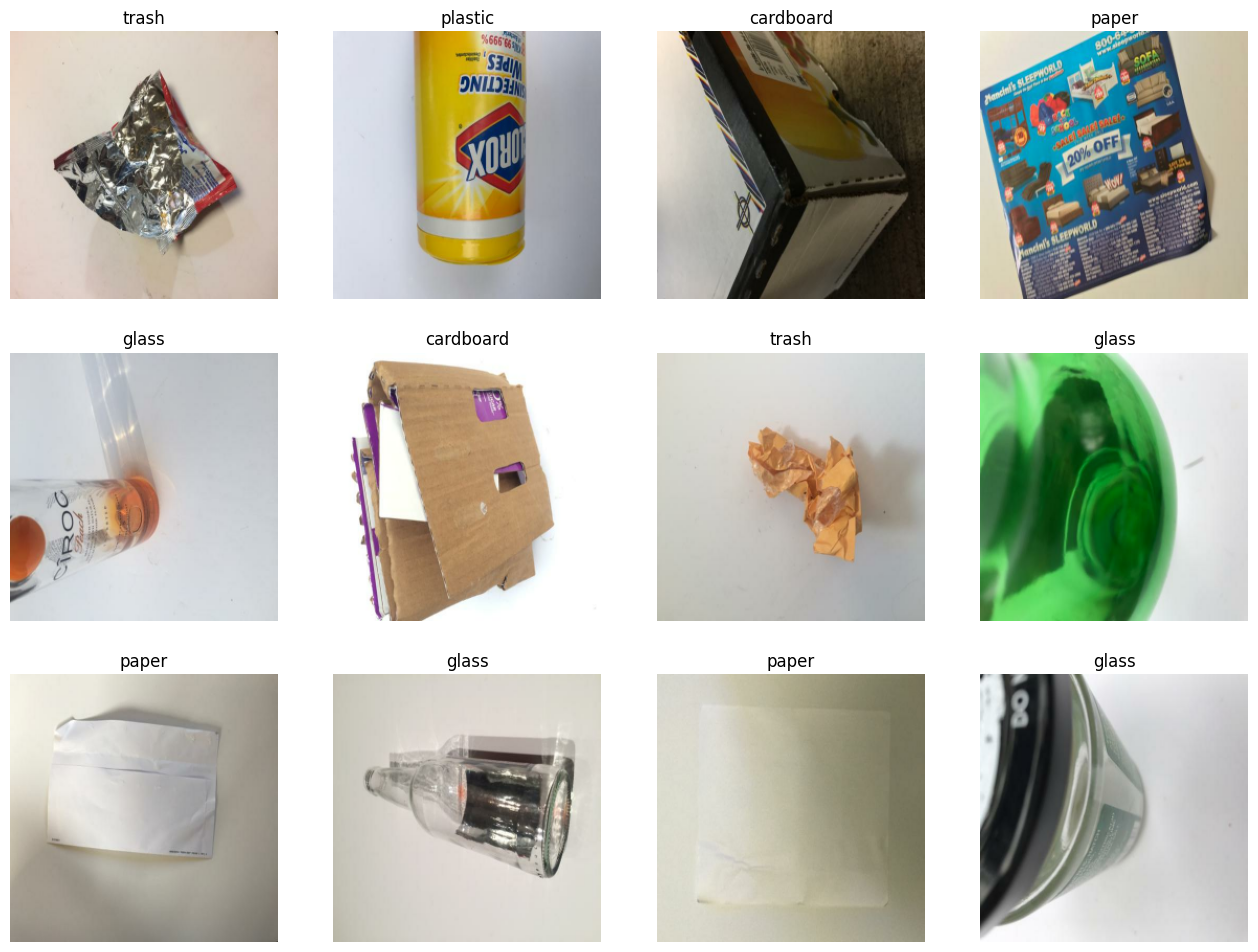

In [10]:
#Viewing some images from the Training Dataset
plt.figure(figsize=(16, 16))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

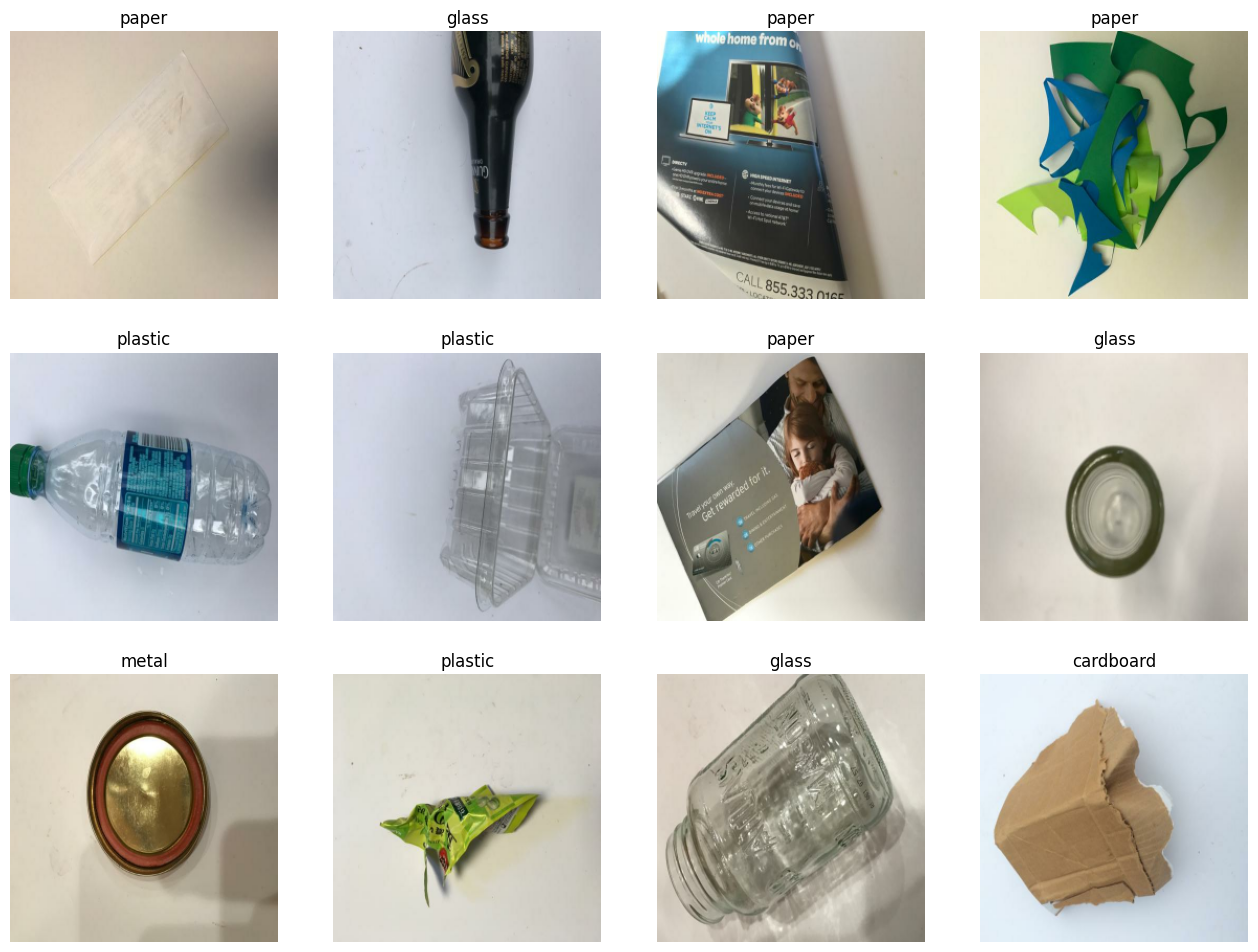

In [11]:
#Viewing some images from the Validation Dataset
plt.figure(figsize=(16, 16))
for images, labels in validation_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
#Inspect the Training Dataset
train_batch = train_ds.as_numpy_iterator().next()

print('total of batches:',len(train_ds))
print('images batch shape:',train_batch[0].shape)
print('labels batch shape:',train_batch[1].shape)

total of batches: 64
images batch shape: (32, 256, 256, 3)
labels batch shape: (32,)


In [13]:
#Inspect the Validation Dataset
validation_batch = validation_ds.as_numpy_iterator().next()

print('total of batches:',len(validation_ds))
print('images batch shape:',validation_batch[0].shape)
print('labels batch shape:',validation_batch[1].shape)

total of batches: 16
images batch shape: (32, 256, 256, 3)
labels batch shape: (32,)


# **2. Neural Network**

##**2.1 Instantiating ResNet50V2 for fine-tuning**

In [14]:
#Instantiating the base model
input_shape = (256,256,3)
base_model = tf.keras.applications.ResNet50V2(include_top=False, input_shape=input_shape)

#Making the layers of the model trainable
base_model.trainable = True

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


##**2.2 Reviewing the Model**

In [15]:
#Reviewing the base model architecture
base_model.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 64, 64,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 64, 64,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 66, 66,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 64, 64,    │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [16]:
#Finding the tunning layer and its index
tuning_layer_name = 'conv5_block1_preact_bn'
tuning_layer = base_model.get_layer(tuning_layer_name)
tuning_index = base_model.layers.index(tuning_layer)

#Freezing all the layers before the tuning layer
for layer in base_model.layers[:tuning_index]:
    layer.trainable =  False

##**2.3 Changing Orientation of Images for Better Precision**

In [17]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./127.5, offset=-1),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

##**2.4 Creating the architecture**

In [18]:
#Creating the neural network architecture
import tensorflow as tf
model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(6, activation='softmax')
])

learning_rate = 0.00001
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    metrics=['accuracy']
)

##**2.5 Training the Model**

In [ ]:
#Training the model
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=100
)

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 35s 290ms/step - accuracy: 0.2626 - loss: 1.7689 - val_accuracy: 0.5842 - val_loss: 1.1457
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 227ms/step - accuracy: 0.6244 - loss: 1.1312 - val_accuracy: 0.6970 - val_loss: 0.8511
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 231ms/step - accuracy: 0.7299 - loss: 0.8442 - val_accuracy: 0.7406 - val_loss: 0.7028
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 240ms/step - accuracy: 0.7804 - loss: 0.7145 - val_accuracy: 0.7861 - val_loss: 0.6172
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 232ms/step - accuracy: 0.8135 - loss: 0.5871 - val_accuracy: 0.8059 - val_loss: 0.5620
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 230ms/step - accuracy: 0.8353 - loss: 0.5202 - val_accuracy: 0.8158 - val_loss: 0.5110
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 230ms/step - accuracy: 0.8576 - loss: 0.4600 - val_accuracy: 0.8337 - val_loss: 0.4681
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 237ms/step - accuracy: 0.8843 - loss: 0.4000 - 

In [ ]:
#Visualizing the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#Plotting accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

#Plotting loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **3. Model Evaluation**

##**3.1 Evaluating the Model**

In [ ]:
#Verifying the performance of the model
loss, accuracy = model.evaluate(validation_ds)
print('Test accuracy :', accuracy)
print('Test loss:', loss)

##**3.2 Saving the Model**

In [ ]:
model.save('/content/drive/MyDrive/EcoIdentify_classification_model.h5')

# **4. Inferencing**

## **4.1. Inference Using Known Data**

In [ ]:
#Get a batch from Validation Dataset to do some inferencing
image_batch, label_batch = validation_ds.as_numpy_iterator().next()

#Inference
inference = model.predict_on_batch(image_batch)

#Viewing images and labels
plt.figure(figsize=(18, 18))
for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title('Inference:{}, {:.2f}% Confidence\nReal Label:{}'
              .format(class_names[np.argmax(inference[i])], 100 * np.max(inference[i]), class_names[label_batch[i]]))
    plt.axis("off")

#Ending Notes

The model should've saved a file named *EcoIdentify_classification_model.h5* in my drive. Refer to [deployment](https://huggingface.co/spaces/EcoClim-Solution/EcoIdentify) to learn how to use this file.

Please note as of July 7th, 2025, the deployment is currently under maintenance and we are working to get it back to pace. In the meantime, please view our Roboflow deployment at [Streamlit](https://ecoidentifyv3.streamlit.app/).